In [1]:
from __future__ import print_function, division
from IPython.core import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# if you're running in colab
# !wget https://raw.githubusercontent.com/yandexdataschool/Practical_RL/0ccb0673965dd650d9b284e1ec90c2bfd82c8a94/week08_pomdp/atari_util.py
# !wget https://raw.githubusercontent.com/yandexdataschool/Practical_RL/0ccb0673965dd650d9b284e1ec90c2bfd82c8a94/week08_pomdp/env_pool.py

# If you are running on a server, launch xvfb to record game videos
# Please make sure you have xvfb installed
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    %env DISPLAY = : 1

env: DISPLAY=: 1


../xvfb: line 5: syntax error near unexpected token `$'in\r''
../xvfb: line 5: `case "$1" in
'


### Kung-Fu, recurrent style

In this notebook we'll once again train RL agent for for atari [KungFuMaster](https://gym.openai.com/envs/KungFuMaster-v0/), this time using recurrent neural networks.

![http://www.retroland.com/wp-content/uploads/2011/07/King-Fu-Master.jpg](http://www.retroland.com/wp-content/uploads/2011/07/King-Fu-Master.jpg)

In [2]:
import gym
from atari_util import PreprocessAtari


def make_env():
    env = gym.make("KungFuMasterDeterministic-v0")
    env = PreprocessAtari(env, height=42, width=42,
                          crop=lambda img: img[60:-30, 15:],
                          color=False, n_frames=1)
    return env


env = make_env()

obs_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation shape:", obs_shape)
print("Num actions:", n_actions)
print("Action names:", env.env.env.get_action_meanings())

Observation shape: (1, 42, 42)
Num actions: 14
Action names: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


C:\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


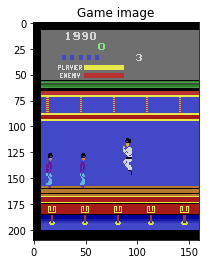

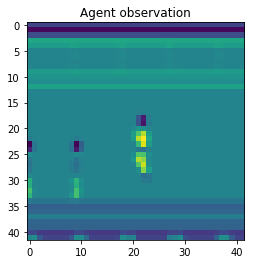

In [3]:
s = env.reset()
for _ in range(100):
    s, _, _, _ = env.step(env.action_space.sample())

plt.title('Game image')
plt.imshow(env.render('rgb_array'))
plt.show()

plt.title('Agent observation')
plt.imshow(s.reshape([42, 42]))
plt.show()

### POMDP setting

The atari game we're working with is actually a POMDP: your agent needs to know timing at which enemies spawn and move, but cannot do so unless it has some memory. 

Let's design another agent that has a recurrent neural net memory to solve this. Here's a sketch.

![img](img1.jpg)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# a special module that converts [batch, channel, w, h] to [batch, units]


class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [5]:
class SimpleRecurrentAgent(nn.Module):
    def __init__(self, obs_shape, n_actions, reuse=False):
        """A simple actor-critic agent"""
        super(self.__class__, self).__init__()

        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
        self.conv1 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
        self.flatten = Flatten()

        self.hid = nn.Linear(512, 128)
        self.rnn = nn.LSTMCell(128, 128)

        self.logits = nn.Linear(128, n_actions)
        self.state_value = nn.Linear(128, 1)

    def forward(self, prev_state, obs_t):
        """
        Takes agent's previous step and observation, 
        returns next state and whatever it needs to learn (tf tensors)
        """

        # YOUR CODE: apply the whole neural net for one step here.
        # See docs on self.rnn(...)
        # the recurrent cell should take the last feedforward dense layer as input
        hidden = F.elu(self.conv0(obs_t))
        hidden = F.elu(self.conv1(hidden))
        hidden = F.elu(self.conv2(hidden))
        
        hidden = self.flatten(hidden)
        
        hidden = F.relu(self.hid(hidden))

        new_state = self.rnn(hidden, prev_state)
        logits = self.logits(new_state[0])
        state_value = self.state_value(new_state[0])

        return new_state, (logits, state_value)

    def get_initial_state(self, batch_size):
        """Return a list of agent memory states at game start. Each state is a np array of shape [batch_size, ...]"""
        return torch.zeros((batch_size, 128)).cuda(), torch.zeros((batch_size, 128)).cuda()

    def sample_actions(self, agent_outputs):
        """pick actions given numeric agent outputs (np arrays)"""
        logits, state_values = agent_outputs
        probs = F.softmax(logits)
        return torch.multinomial(probs, 1)[:, 0].data.cpu().numpy()

    def step(self, prev_state, obs_t):
        """ like forward, but obs_t is a numpy array """
        obs_t = torch.tensor(np.asarray(obs_t), dtype=torch.float32).cuda()
        (h, c), (l, s) = self.forward(prev_state, obs_t)
        return (h.detach(), c.detach()), (l.detach(), s.detach())

In [6]:
n_parallel_games = 5
gamma = 0.99

agent = SimpleRecurrentAgent(obs_shape, n_actions).cuda()

In [7]:
state = [env.reset()]
_, (logits, value) = agent.step(agent.get_initial_state(1), state)
print("action logits:\n", logits)
print("state values:\n", value)

action logits:
 tensor([[ 0.0433,  0.0021, -0.0396,  0.0510,  0.0153,  0.0476, -0.0045,  0.0378,
          0.0804, -0.0269, -0.0027, -0.0677,  0.0183,  0.0455]],
       device='cuda:0')
state values:
 tensor([[0.0575]], device='cuda:0')


### Let's play!
Let's build a function that measures agent's average reward.

In [8]:
def evaluate(agent, env, n_games=1):
    """Plays an entire game start to end, returns session rewards."""

    game_rewards = []
    for _ in range(n_games):
        # initial observation and memory
        observation = env.reset()
        prev_memories = agent.get_initial_state(1)

        total_reward = 0
        while True:
            new_memories, readouts = agent.step(
                prev_memories, observation[None, ...])
            action = agent.sample_actions(readouts)

            observation, reward, done, info = env.step(action[0])

            total_reward += reward
            prev_memories = new_memories
            if done:
                break

        game_rewards.append(total_reward)
    return game_rewards

In [9]:
env_monitor = gym.wrappers.Monitor(env, directory="kungfu_videos", force=True)
rw = evaluate(agent, env_monitor, n_games=3,)
env_monitor.close()
print(rw)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[400.0, 0.0, 700.0]


In [10]:
# show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s: s.endswith(
    ".mp4"), os.listdir("./kungfu_videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./kungfu_videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices

### Training on parallel games

We introduce a class called EnvPool - it's a tool that handles multiple environments for you. Here's how it works:
![img](img2.jpg)

In [11]:
from env_pool import EnvPool
pool = EnvPool(agent, make_env, n_parallel_games)

C:\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


We gonna train our agent on a thing called __rollouts:__
![img](img3.jpg)

A rollout is just a sequence of T observations, actions and rewards that agent took consequently.
* First __s0__ is not necessarily initial state for the environment
* Final state is not necessarily terminal
* We sample several parallel rollouts for efficiency

In [12]:
# for each of n_parallel_games, take 10 steps
rollout_obs, rollout_actions, rollout_rewards, rollout_mask = pool.interact(10)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [13]:
print("Actions shape:", rollout_actions.shape)
print("Rewards shape:", rollout_rewards.shape)
print("Mask shape:", rollout_mask.shape)
print("Observations shape: ", rollout_obs.shape)

Actions shape: (5, 10)
Rewards shape: (5, 10)
Mask shape: (5, 10)
Observations shape:  (5, 10, 1, 42, 42)


# Actor-critic objective

Here we define a loss function that uses rollout above to train advantage actor-critic agent.


Our loss consists of three components:

* __The policy "loss"__
 $$ \hat J = {1 \over T} \cdot \sum_t { \log \pi(a_t | s_t) } \cdot A_{const}(s,a) $$
  * This function has no meaning in and of itself, but it was built such that
  * $ \nabla \hat J = {1 \over N} \cdot \sum_t { \nabla \log \pi(a_t | s_t) } \cdot A(s,a) \approx \nabla E_{s, a \sim \pi} R(s,a) $
  * Therefore if we __maximize__ J_hat with gradient descent we will maximize expected reward
  
  
* __The value "loss"__
  $$ L_{td} = {1 \over T} \cdot \sum_t { [r + \gamma \cdot V_{const}(s_{t+1}) - V(s_t)] ^ 2 }$$
  * Ye Olde TD_loss from q-learning and alike
  * If we minimize this loss, V(s) will converge to $V_\pi(s) = E_{a \sim \pi(a | s)} R(s,a) $


* __Entropy Regularizer__
  $$ H = - {1 \over T} \sum_t \sum_a {\pi(a|s_t) \cdot \log \pi (a|s_t)}$$
  * If we __maximize__ entropy we discourage agent from predicting zero probability to actions
  prematurely (a.k.a. exploration)
  
  
So we optimize a linear combination of $L_{td}$ $- \hat J$, $-H$
  
```

```

```

```

```

```


__One more thing:__ since we train on T-step rollouts, we can use N-step formula for advantage for free:
  * At the last step, $A(s_t,a_t) = r(s_t, a_t) + \gamma \cdot V(s_{t+1}) - V(s) $
  * One step earlier, $A(s_t,a_t) = r(s_t, a_t) + \gamma \cdot r(s_{t+1}, a_{t+1}) + \gamma ^ 2 \cdot V(s_{t+2}) - V(s) $
  * Et cetera, et cetera. This way agent starts training much faster since it's estimate of A(s,a) depends less on his (imperfect) value function and more on actual rewards. There's also a [nice generalization](https://arxiv.org/abs/1506.02438) of this.


__Note:__ it's also a good idea to scale rollout_len up to learn longer sequences. You may wish set it to >=20 or to start at 10 and then scale up as time passes.

In [14]:
def to_one_hot(y, n_dims=None):
    """ Take an integer tensor and convert it to 1-hot matrix. """
    y_tensor = y.to(dtype=torch.int64).view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims).cuda().scatter_(1, y_tensor, 1)
    return y_one_hot

In [15]:
opt = torch.optim.Adam(agent.parameters(), lr=1e-5)


def train_on_rollout(states, actions, rewards, is_not_done, prev_memory_states, gamma=0.99):
    """
    Takes a sequence of states, actions and rewards produced by generate_session.
    Updates agent's weights by following the policy gradient above.
    Please use Adam optimizer with default parameters.
    """

    # shape: [batch_size, time, c, h, w]
    states = torch.tensor(np.asarray(states), dtype=torch.float32).cuda()
    actions = torch.tensor(np.array(actions), dtype=torch.int64).cuda()  # shape: [batch_size, time]
    rewards = torch.tensor(np.array(rewards), dtype=torch.float32).cuda()  # shape: [batch_size, time]
    is_not_done = torch.tensor(np.array(is_not_done), dtype=torch.float32).cuda()  # shape: [batch_size, time]
    rollout_length = rewards.shape[1] - 1

    # predict logits, probas and log-probas using an agent.
    memory = [m.detach() for m in prev_memory_states]

    logits = []  # append logit sequence here
    state_values = []  # append state values here
    for t in range(rewards.shape[1]):
        obs_t = states[:, t]

        # use agent to comute logits_t and state values_t.
        # append them to logits and state_values array

        memory, (logits_t, values_t) = agent.forward(memory, obs_t)

        logits.append(logits_t)
        state_values.append(values_t)

    logits = torch.stack(logits, dim=1)
    state_values = torch.stack(state_values, dim=1)
    probas = F.softmax(logits, dim=2)
    logprobas = F.log_softmax(logits, dim=2)

    # select log-probabilities for chosen actions, log pi(a_i|s_i)
    actions_one_hot = to_one_hot(actions, n_actions).view(
        actions.shape[0], actions.shape[1], n_actions)
    logprobas_for_actions = torch.sum(logprobas * actions_one_hot, dim=-1)

    # Now let's compute two loss components:
    # 1) Policy gradient objective.
    # Notes: Please don't forget to call .detach() on advantage term. Also please use mean, not sum.
    # it's okay to use loops if you want
    J_hat = 0  # policy objective as in the formula for J_hat

    # 2) Temporal difference MSE for state values
    # Notes: Please don't forget to call on V(s') term. Also please use mean, not sum.
    # it's okay to use loops if you want
    value_loss = 0

    cumulative_returns = state_values[:, -1].detach()

    for t in reversed(range(rollout_length)):
        r_t = rewards[:, t]                                # current rewards
        # current state values
        V_t = state_values[:, t]
        V_next = state_values[:, t + 1].detach()           # next state values
        # log-probability of a_t in s_t
        logpi_a_s_t = logprobas_for_actions[:, t]

        # update G_t = r_t + gamma * G_{t+1} as we did in week6 reinforce
        cumulative_returns = G_t = r_t + gamma * cumulative_returns

        # Compute temporal difference error (MSE for V(s))
        value_loss += torch.mean((r_t + gamma*V_next - V_t)**2)

        # compute advantage A(s_t, a_t) using cumulative returns and V(s_t) as baseline
        advantage = cumulative_returns - V_t
        advantage = advantage.detach()

        # compute policy pseudo-loss aka -J_hat.
        J_hat += torch.mean(logpi_a_s_t*advantage)

    # regularize with entropy
    entropy_reg = -torch.mean(torch.sum(probas*logprobas, dim=-1))

    # add-up three loss components and average over time
    loss = -J_hat / rollout_length +\
        value_loss / rollout_length +\
           -0.01 * entropy_reg

    # Gradient descent step
    opt.zero_grad()
    loss.backward()
    opt.step()

    return loss.data.cpu().numpy()

In [16]:
# let's test it
memory = list(pool.prev_memory_states)
rollout_obs, rollout_actions, rollout_rewards, rollout_mask = pool.interact(10)

train_on_rollout(rollout_obs, rollout_actions,
                 rollout_rewards, rollout_mask, memory)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


array(-0.03387793, dtype=float32)

# Train 

just run train step and see if agent learns any better

In [17]:
from IPython.display import clear_output
from tqdm import trange
from pandas import DataFrame
moving_average = lambda x, **kw: DataFrame(
    {'x': np.asarray(x)}).x.ewm(**kw).mean().values

rewards_history = []

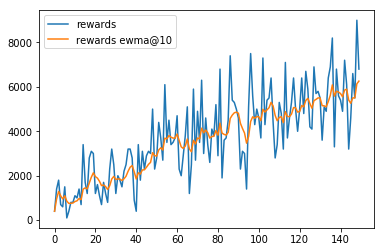

100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [48:44<00:00,  7.13it/s]


In [18]:
for i in trange(15000):

    memory = list(pool.prev_memory_states)
    rollout_obs, rollout_actions, rollout_rewards, rollout_mask = pool.interact(
        10)
    train_on_rollout(rollout_obs, rollout_actions,
                     rollout_rewards, rollout_mask, memory)

    if i % 100 == 0:
        rewards_history.append(np.mean(evaluate(agent, env, n_games=1)))
        clear_output(True)
        plt.plot(rewards_history, label='rewards')
        plt.plot(moving_average(np.array(rewards_history),
                                span=10), label='rewards ewma@10')
        plt.legend()
        plt.show()
        if rewards_history[-1] >= 10000:
            print("Your agent has just passed the minimum homework threshold")
            break

15 тысяч итераций не хватило, чтобы побить порог, запустим еще раз:

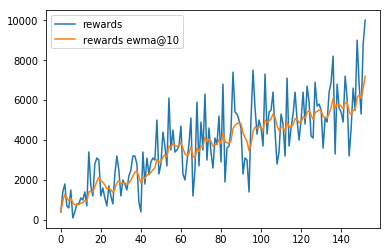

Your agent has just passed the minimum homework threshold


In [19]:
for i in trange(15000):

    memory = list(pool.prev_memory_states)
    rollout_obs, rollout_actions, rollout_rewards, rollout_mask = pool.interact(
        10)
    train_on_rollout(rollout_obs, rollout_actions,
                     rollout_rewards, rollout_mask, memory)

    if i % 100 == 0:
        rewards_history.append(np.mean(evaluate(agent, env, n_games=1)))
        clear_output(True)
        plt.plot(rewards_history, label='rewards')
        plt.plot(moving_average(np.array(rewards_history),
                                span=10), label='rewards ewma@10')
        plt.legend()
        plt.show()
        if rewards_history[-1] >= 10000:
            print("Your agent has just passed the minimum homework threshold")
            break

Relax and grab some refreshments while your agent is locked in an infinite loop of violence and death.

__How to interpret plots:__

The session reward is the easy thing: it should in general go up over time, but it's okay if it fluctuates ~~like crazy~~. It's also OK if it reward doesn't increase substantially before some 10k initial steps. However, if reward reaches zero and doesn't seem to get up over 2-3 evaluations, there's something wrong happening.


Since we use a policy-based method, we also keep track of __policy entropy__ - the same one you used as a regularizer. The only important thing about it is that your entropy shouldn't drop too low (`< 0.1`) before your agent gets the yellow belt. Or at least it can drop there, but _it shouldn't stay there for long_.

If it does, the culprit is likely:
* Some bug in entropy computation. Remember that it is $ - \sum p(a_i) \cdot log p(a_i) $
* Your agent architecture converges too fast. Increase entropy coefficient in actor loss. 
* Gradient explosion - just [clip gradients](https://stackoverflow.com/a/43486487) and maybe use a smaller network
* Us. Or TF developers. Or aliens. Or lizardfolk. Contact us on forums before it's too late!

If you're debugging, just run `logits, values = agent.step(batch_states)` and manually look into logits and values. This will reveal the problem 9 times out of 10: you'll likely see some NaNs or insanely large numbers or zeros. Try to catch the moment when this happens for the first time and investigate from there.

### "Final" evaluation

In [20]:
env_monitor = gym.wrappers.Monitor(env, directory="kungfu_videos", force=True)
final_rewards = evaluate(agent, env_monitor, n_games=20,)
env_monitor.close()
print("Final mean reward", np.mean(final_rewards))

video_names = list(filter(lambda s: s.endswith(
    ".mp4"), os.listdir("./kungfu_videos/")))
HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./kungfu_videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Final mean reward 5725.0
